In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/home/rkube/ml4control'

In [4]:
import logging
from yaml import load, Loader

from os.path import join

import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import sys
# USe the D3D loader to fetch and prepare data
# https://github.com/PlasmaControl/d3d_loaders
sys.path.append("/home/rkube/repos/d3d_loaders")

In [6]:
from d3d_loaders.d3d_loaders import D3D_dataset, Multishot_dataset
from d3d_loaders.samplers import RandomBatchSequenceSampler_multishot, collate_fn_random_batch_seq_multi
from d3d_loaders.samplers import SequentialSamplerBatched, collate_fn_seq_batched
from d3d_loaders.samplers import SequentialSamplerBatched_multi

In [5]:
logging.basicConfig(filename="AE_pred_154xxx_trf.log",
                 filemode='a',
                 format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                 datefmt='%H:%M:%S',
                 level=logging.DEBUG)

# Load dataset definition

In [7]:
with open("AE_pred_154xxx_small.yaml", "r") as fp:
    config = load(fp, Loader=Loader)
print(config)

{'predictors': ['pcbcoil', 'iptipp', 'kappa', 'echpwrc', 'bmspinj', 'bmstinj', 'tritop', 'tribot', 'dssdenest'], 'targets': ['AE_predictions', 'betan'], 'setup': {'tparams': {'tstart': 200.0, 'tend': 2000.0, 'tsample': 1.0}, 'tshift': 20.0}, 'shots': {'train': [132228, 140914, 141223, 152827, 153061, 154121, 154123, 158523, 159260, 165762], 'valid': [132236, 141215]}}


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# This part is a bit tricky, due to the internals of the loader.
seq_length = 96  # Used as input to the transformer
tgt_length = 32  # Length of the target sequence passed into and returned by the transformer
shift = 16        # Input to the decoder is a series of length tgt_length. But this sequence is shifted
                 # back by shift compared to the output.
                 # So, shift is the actual number of features predicted beyond what is input to the model.

# Load length is the length of sequences returned by the data loader.
# Remember that the loader internally adds one to this
load_length = seq_length + tgt_length - 1

batch_size = 32

print(f"load_length = {load_length}")

load_length = 127


## Instantiate training set and validation sets

This transformer example is a bit different than the LSTM example. Since the transformer requires
a context (the target vector passed into the decoder), which is shifted forward in time w.r.t the input,
we set `shift_targets=0`. That is, when `(x,y) = next(iter(loader))`, the sequences in `x` and `y` will
be at the same samples.


In [9]:
# Manually set time shift in predictors to 0.
ds_train = Multishot_dataset(config["shots"]["train"], config["setup"]["tparams"],
                             predictors=config["predictors"],
                             targets=config["targets"],
                             shift_targets={k: 0.0 for k in config["targets"]},
                             datapath="/projects/EKOLEMEN/AE_datasets/AE_RT_dataset1", 
                             device=device)

In [10]:
ds_valid = Multishot_dataset(config["shots"]["valid"], config["setup"]["tparams"],
                            predictors=config["predictors"],
                            targets=config["targets"],
                            shift_targets={k: 0.0 for k in config["targets"]},
                            datapath="/projects/EKOLEMEN/AE_datasets/AE_RT_dataset1",  
                            device=device)

## Instantiate data loaders

The dataloader for the training set is sampled using a RandomBatchSequenceSampler_multishot.
This returns sequences, that start at random points, throughout the list of shots.

The dataloader for the validation set samples the sequences in order. Sequence 0 in batch 0 starts at
sample 0. Sequence 1 in batch 0 starts at sample 1.



In [11]:
loader_train = torch.utils.data.DataLoader(ds_train, num_workers=0, 
                                           batch_sampler=RandomBatchSequenceSampler_multishot(len(config["shots"]["train"]), len(ds_train.shot(0)), load_length, batch_size),
                                           collate_fn = collate_fn_random_batch_seq_multi(batch_size))

loader_valid = torch.utils.data.DataLoader(ds_valid, num_workers=0, 
                                           batch_sampler=SequentialSamplerBatched_multi(len(config["shots"]["valid"]), len(ds_valid.shot(0)), load_length, batch_size),
                                           collate_fn = collate_fn_random_batch_seq_multi(batch_size))


In [12]:
# Test that we can iterate through the datasets.
for _ in loader_train:
    continue

for _ in loader_valid:
    continue

# Define a transformer model
Following [this tutorial](https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e)

Original paper [Wu et al. (2020)](https://arxiv.org/pdf/2001.08317.pdf)

Architecture

![architecture](plots/wu_transformer_arch.png)

### Cells below are for debugging shape issues.

In [13]:
xb, yb = next(iter(loader_train))    
print(xb.shape, yb.shape)
xc = xb.to("cpu")
yc = yb.to("cpu")

xv, yv = next(iter(loader_valid))
print(xv.shape, yv.shape)

torch.Size([128, 32, 9]) torch.Size([128, 32, 6])
torch.Size([128, 32, 9]) torch.Size([128, 32, 6])


In [14]:
print(xc.shape, xc[:seq_length,:,:].shape, xc[seq_length:,:,:].shape)
print(yc.shape, yc[:seq_length,:,:].shape, yc[seq_length:,:,:].shape)


torch.Size([128, 32, 9]) torch.Size([96, 32, 9]) torch.Size([32, 32, 9])
torch.Size([128, 32, 6]) torch.Size([96, 32, 6]) torch.Size([32, 32, 6])


In [15]:
print(xc[:,0,0])
print(xc[:seq_length,0,0])
print(xc[seq_length:,0,0])

tensor([-1.5210, -1.5210, -0.7739, -0.5872, -0.4004, -0.2135,  0.1600,  0.3468,
         0.7203,  1.0938,  0.9070, -0.0268, -0.5872, -1.3342, -1.7077, -1.7077,
        -1.5210, -1.5210, -1.7077, -0.5872, -0.2135, -0.2135,  0.9070,  0.5335,
         0.1600, -0.2135,  0.5335,  0.1600, -0.5872, -0.9607, -1.5210, -1.5210,
        -1.3342, -1.3342, -1.7077, -0.9607, -0.2135, -0.0268, -0.2135,  0.1600,
        -0.2135, -0.4004, -0.2135,  0.1600, -0.4004, -0.9607, -0.9607, -1.5210,
        -1.3342, -1.3342, -0.9607, -1.8945, -0.9607, -0.7739, -0.2135, -0.2135,
         0.1600, -0.7739, -0.7739, -0.2135,  0.1600, -0.0268, -0.7739, -0.7739,
        -1.1474, -1.5210, -1.3342, -1.5210, -1.7077, -1.1474, -0.5872, -0.7739,
        -0.0268, -0.2135, -0.5872, -0.2135,  0.3468,  0.7203, -0.2135, -0.5872,
        -1.7077, -2.0812, -1.5210, -1.8945, -1.8945, -1.8945, -1.1474, -0.7739,
        -0.7739, -0.0268,  0.1600, -0.2135, -0.2135,  0.1600, -0.0268, -0.9607,
        -1.1474, -1.8945, -2.0812, -1.70

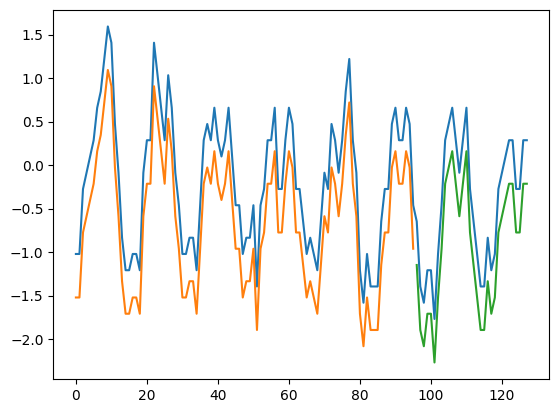

In [16]:
plt.plot(xc[:, 0, 0].detach().numpy() + 0.5)
plt.plot(np.arange(seq_length), xc[:seq_length, 0, 0].detach().numpy())
plt.plot(np.arange(seq_length, seq_length+tgt_length), xc[seq_length:, 0, 0].detach().numpy())

In [17]:
inp_size = xc.shape[-1]   # Input dimension}
int_dim = 128  # Size of internal states
out_size = yc.shape[-1]   # Output dimension

print(f"inp_size={inp_size}, int_dim={int_dim}, out_size={out_size}")

inp_size=9, int_dim=128, out_size=6


In [18]:
# Transforms features dimension (dim=2) from inp_size to int_dim
t_input_layer = nn.Linear(inp_size, int_dim)
t_input_layer(xc[:seq_length, :, :]).shape

torch.Size([96, 32, 128])

## Define a positional encoding.

In [22]:
## Define positional encoding
class PositionalEncoder(nn.Module):
    """Positional encoding
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model=512, dropout=1e-1, max_seq_len=5000, batch_first=False):
        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        self.x_dim = 1 if batch_first else 0
        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        x = x + self.pe[:x.size(self.x_dim)]
        return self.dropout(x)

In [23]:
t_posenc = PositionalEncoder(d_model=int_dim, dropout=0.1)

In [24]:
t_posenc(t_input_layer(xc[:-1, :, :])).shape

torch.Size([127, 32, 128])

In [25]:
t_enc_layer = nn.TransformerEncoderLayer(d_model=int_dim, nhead=4)
t_enc = nn.TransformerEncoder(encoder_layer=t_enc_layer, num_layers=2, norm=None)

In [26]:
t_enc_layer(t_posenc(t_input_layer(xc[:-1, :, :]))).shape
t_enc(t_posenc(t_input_layer(xc[:-1, :, :]))).shape

torch.Size([127, 32, 128])

In [27]:
# Now build the decoder.
t_decoder_inp = nn.Linear(in_features=out_size, out_features=int_dim)

t_dec_layer = nn.TransformerDecoderLayer(d_model=int_dim, nhead=4, batch_first=True)
t_dev = nn.TransformerDecoder(decoder_layer=t_dec_layer, num_layers=4)

In [28]:
# Final linear mapping layer
t_linmap = nn.Linear(int_dim, out_size)

In [29]:
class TimeSeriesTransformer(nn.Module):
    """Transformer for time series forecasting.
    
    Source: https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    Paper: Wu, N., Green, B., Ben, X., O'banion, S. (2020): 'Deep Transformer Models for Time Series Forecasting   
    """
    def __init__(self, input_size, dec_seq_len, batch_first, out_seq_len, dim_val,
                 n_encoder_layers, n_decoder_layers, dropout_enc, dropout_dec, dropout_pe, nhead,
                 dim_ff_enc, dim_ff_dec, n_pred_fts):
        """
        Args:
            input_size: number of input variables
            dec_seq_len: Length of the input size fed to the decoder
            dim_val: All sub-layers in the model produce outputs of dimension dim_val
            n_encoder_layers: Number of stacked encoder layers in the encoder
            n_decoder_layers: Number of stacked decoder_layers in the decoder
            dropout_enc: dropout prob used in encoder
            dropout_dec: dropout prob used in decoder
            dropout_pe: dropout prob used in positional encoding
            nhead: Number of attention heads
            dim_ff_enc: feed-forward layer size in linear layer of the encoder
            dim_ff_dec: feed-forward layer size in linear layer of the decoder
            n_pred_fts: number of predicted features
        """
        super(TimeSeriesTransformer, self).__init__()
        self.encoder_input_layer = nn.Linear(input_size, dim_val)  # Maps input to internal size
        self.decoder_input_layer = nn.Linear(n_pred_fts, dim_val)  # Maps output to internal size
        self.linear_mapping = nn.Linear(dim_val, n_pred_fts)       # Maps internal size to output
        self.pos_enc = PositionalEncoder(d_model=dim_val, dropout=dropout_pe)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_val, nhead=nhead,
                                                   dim_feedforward=dim_ff_enc,
                                                   dropout=dropout_enc,
                                                   batch_first=batch_first)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=n_encoder_layers, norm=None)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_val, nhead=nhead,
                                                   dim_feedforward=dim_ff_dec,
                                                   dropout=dropout_dec,
                                                   batch_first=batch_first)
        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=n_decoder_layers, norm=None)
        
        
    def forward(self, src, target, src_mask, target_mask):
        """
        Returns a tensor of shape:
            [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """
        #print(f"From model.forward(): Size of src as given to forward(): {src.shape}")
        #print(f"From model.forward(): target size = {target.size()}")

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print(f"From model.forward(): Size of src after input layer: {src.shape}")

        # Pass through the positional encoding layer
        src = self.pos_enc(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print(f"From model.forward(): Size of src after pos_enc layer: {src.shape}")
        # src shape: [batch_size, enc_seq_len, dim_val]
        src = self.encoder(src=src)
        #print(f"From model.forward(): Size of src after encoder: {src.shape}")
        
        # Pass decoder input through through decoder input layer:
        #print(f"From model.forward(): Size of target: {target.shape}")
        decoder_out = self.decoder_input_layer(target) #[None, :, :]  # for tgt_length=1: Squeeze in a first dimension for length of predicted sequence
        #print(f"From model.forward(): Size of decoder_out after linear decoder layer: {decoder_out.shape}")

        # Pass through decoder:
        decoder_out = self.decoder(tgt=decoder_out, memory=src, tgt_mask=target_mask, memory_mask=src_mask)
        #print(f"From model.forward(): decoder_out shape after decoder: {decoder_out.shape}")

        # Pass through linear mapping
        decoder_out = self.linear_mapping(decoder_out) # shape [batch_size, target seq len]
        #print(f"From model.forward(): decoder_out size after linear_mapping = {decoder_out.shape}")
        
        return decoder_out
    

In [30]:
# Generate masks: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
src_mask = torch.triu(torch.ones(tgt_length, seq_length) * float('-inf'), diagonal=1).to(device)
tgt_mask = torch.triu(torch.ones(tgt_length, tgt_length) * float('-inf'), diagonal=1).to(device)

In [31]:
yc.shape, xc.shape, src_mask.shape, tgt_mask.shape

(torch.Size([128, 32, 6]),
 torch.Size([128, 32, 9]),
 torch.Size([32, 96]),
 torch.Size([32, 32]))

In [32]:
my_trf = TimeSeriesTransformer(inp_size, seq_length, batch_first=False, out_seq_len=tgt_length, dim_val=128,
                              n_encoder_layers=2, n_decoder_layers=4, 
                              dropout_enc=0.1, dropout_dec=0.1, dropout_pe=0.1,
                              nhead=4, dim_ff_enc=1024, dim_ff_dec=1024, n_pred_fts=6).to(device)

loss_fn = nn.MSELoss()

In [33]:
y_pred = my_trf(xb[:seq_length, :, :], yb[(seq_length-shift):(seq_length-shift+tgt_length), :, :], src_mask, tgt_mask)
loss_fn(y_pred, yb[-tgt_length:, :, :])

tensor(1.1878, device='cuda:0', grad_fn=<MseLossBackward0>)

In [34]:
print(xc.shape)
print(xc[:seq_length, :, :].shape), 
print(yc[(seq_length-shift):(seq_length-shift+tgt_length), :, :].shape)
print(yc[-tgt_length:, :, :].shape)

torch.Size([128, 32, 9])
torch.Size([96, 32, 9])
torch.Size([32, 32, 6])
torch.Size([32, 32, 6])


## Define optimizer and train model

In [35]:
optimizer = torch.optim.Adam(my_trf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [36]:
num_epochs = 20

losses_train_epoch = np.zeros(num_epochs)
losses_valid_epoch = np.zeros(num_epochs)

for epoch in range(num_epochs):
    my_trf.train()

    loss_train = 0.0
    loss_valid = 0.0
    for xb, yb in loader_train:
        optimizer.zero_grad()

        output = my_trf(xb[:seq_length, :, :], yb[(seq_length-shift):(seq_length-shift+tgt_length), :, :], src_mask, tgt_mask)

        loss = loss_fn(output, yb[-tgt_length:,:,:])
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        
    with torch.no_grad():
        for xb, yb in loader_valid:
            output = my_trf(xb[:seq_length, :, :], yb[(seq_length-shift):(seq_length-shift+tgt_length), :, :], src_mask, tgt_mask)
            loss_valid += loss_fn(output, yb[-tgt_length:,:,:]).item()
    
    scheduler.step()
    losses_train_epoch[epoch] = loss_train
    losses_valid_epoch[epoch] = loss_valid
    print(f"Epoch {epoch}  train loss = {loss_train:8.6e}, valid loss =  {loss_valid:8.6e}")

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0  train loss = 6.108572e+01, valid loss =  1.052365e+01
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1  train loss = 3.216976e+01, valid loss =  1.088457e+01
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2  train loss = 2.502683e+01, valid loss =  1.245555e+01
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3  train loss = 2.128900e+01, valid loss =  1.449274e+01
Adjusting learning rate of group 0 to 7.5000e-04.
Epoch 4  train loss = 2.046030e+01, valid loss =  1.222390e+01
Adjusting learning rate of group 0 to 7.5000e-04.
Epoch 5  train loss = 1.383898e+01, valid loss =  1.333229e+01
Adjusting learning rate of group 0 to 7.5000e-04.
Epoch 6  train loss = 1.296129e+01, valid loss =  1.204721e+01
Adjusting learning rate of group 0 to 7.5000e-04.
Epoch 7  train loss = 1.283193e+01, valid loss =  1.282485e+01
Adjusting learning rate of group 0 to 7.5000e-04.
Epoch 8  train loss = 1.178990e+01, valid loss

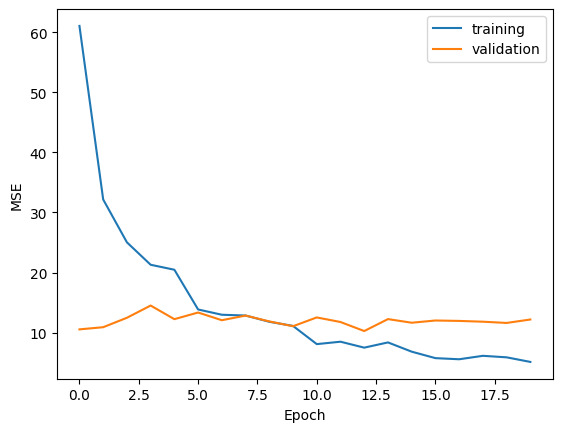

In [37]:
plt.plot(losses_train_epoch, label="training")
plt.plot(losses_valid_epoch, label="validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.savefig(f"trf_training_shift{shift}.png")

## Evaluate model performance

In [38]:
xt, yt = next(iter(loader_train))
print(xt.shape, yt.shape)
print(f"shift = {shift}")
print(range(0, batch_size, shift))

torch.Size([128, 32, 9]) torch.Size([128, 32, 6])
shift = 16
range(0, 32, 16)


In [39]:
ds = ds_valid.shot(0)
loader_valid_single = torch.utils.data.DataLoader(ds, num_workers=0, 
                                                  batch_sampler=SequentialSamplerBatched(len(ds), load_length, batch_size),
                                                  collate_fn = collate_fn_seq_batched())

# Gather predictions for every time slice
target_pred = np.zeros((ds.__len__(), 6))
print(target_pred.shape)

(1800, 6)


In [40]:
# The model outputs shift new data points.
# The loader yields sequences which are offset by 1.
# So we need to collect the output from every shift'th batch ( since the sequences are folded into batches)

for i, (xv, yv) in enumerate(loader_valid_single):
    output = my_trf(xv[:seq_length, :, :], yv[(seq_length-shift):(seq_length-shift+tgt_length), :, :], src_mask, tgt_mask)
    this_batch = shift * (output.shape[1] // shift) # Number of samples in this batch, rounded to smallest multiple of shift
    
    batch_ix = range(0, this_batch, shift)
    # The model effectively predicts only shift elements. Take the entire output sequence length and use that
    # as the predicted values. Skip over the intermediate batches.
    output_s = output.detach().cpu()[-shift:, batch_ix, :]
    #print(f"Setting elements {i * batch_size}:{(i*batch_size + this_batch)}, output_: {output_s.shape}")
    # Lower bound is i*batch_size. Upper bound is i+batch_size + this_batch
    # because only in the last batch would `this_batch` differ from batch_size
    target_pred[(i * batch_size):(i*batch_size + this_batch), :] = output_s.permute((1,0,2)).reshape((output_s.shape[0] * output_s.shape[1], output_s.shape[2]))
    upper = i*batch_size + this_batch

In [41]:
def compare_pred_output(ix_shot, model, ds_valid, shift):
    """Plot model prediction for a single shot in validation set."""
    
    # Make a dataloader for the shot in the validation set
    ds = ds_valid.shot(ix_shot)
    loader_valid_single = torch.utils.data.DataLoader(ds, num_workers=0, 
                                                      batch_sampler=SequentialSamplerBatched(len(ds), load_length, batch_size),
                                                      collate_fn = collate_fn_seq_batched())
    
    # Gather predictions for every time slice
    target_pred = np.zeros((ds.__len__(), 6))

    for i, (xv, yv) in enumerate(loader_valid_single):
        output = my_trf(xv[:seq_length, :, :], yv[(seq_length-shift):(seq_length-shift+tgt_length), :, :], src_mask, tgt_mask)
        this_batch = shift * (output.shape[1] // shift) # Number of samples in this batch, rounded to smallest multiple of shift

        batch_ix = range(0, this_batch, shift)
        # The model effectively predicts only shift elements. Take the entire output sequence length and use that
        # as the predicted values. Skip over the intermediate batches.
        output_s = output.detach().cpu()[-shift:, batch_ix, :]    
        target_pred[(i * this_batch):(i*this_batch + this_batch), :] = output_s.permute((1,0,2)).reshape((output_s.shape[0] * output_s.shape[1], output_s.shape[2]))
    
        
    fig = plt.figure(figsize=(6, 12))
    for ix_ae in range(0, 5):
        plt.subplot(6, 1, ix_ae + 1)

        plt.plot(target_pred[:, ix_ae], label="predicted")
        plt.plot(ds.targets["AE_predictions"].data[seq_length:, ix_ae].cpu().detach().numpy(), label="true")
        plt.xlabel(f"time sample (1 sample = {config['setup']['tparams']['tsample']}ms)")
        plt.ylabel("AE mode probability (standardized)")

        if ix_ae == 0:
            plt.legend()
            plt.title(f"D3D #{ds.shotnr} - shift={shift}")
    plt.subplot(6, 1, 6)
    plt.plot(target_pred[:, -1])
    plt.plot(ds.targets["betan"].data[seq_length:].cpu().detach().numpy())
    plt.ylabel("betan")
    
    return fig



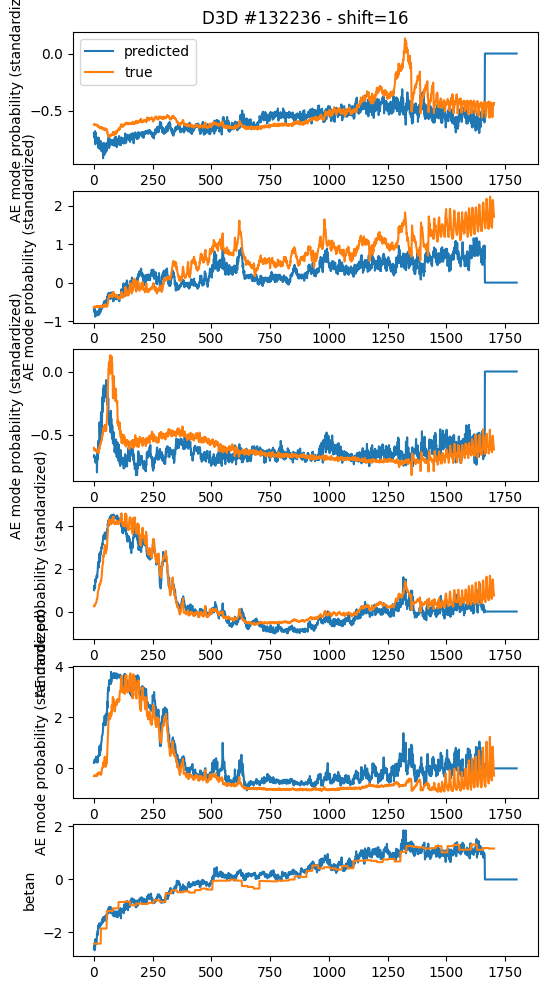

In [42]:
ix_ds = 0
fig = compare_pred_output(ix_ds, my_trf, ds_valid, shift)
fig.savefig(f"AE_pred_transformertest_{ds_valid.shot(ix_ds).shotnr}_shift{shift}.png")

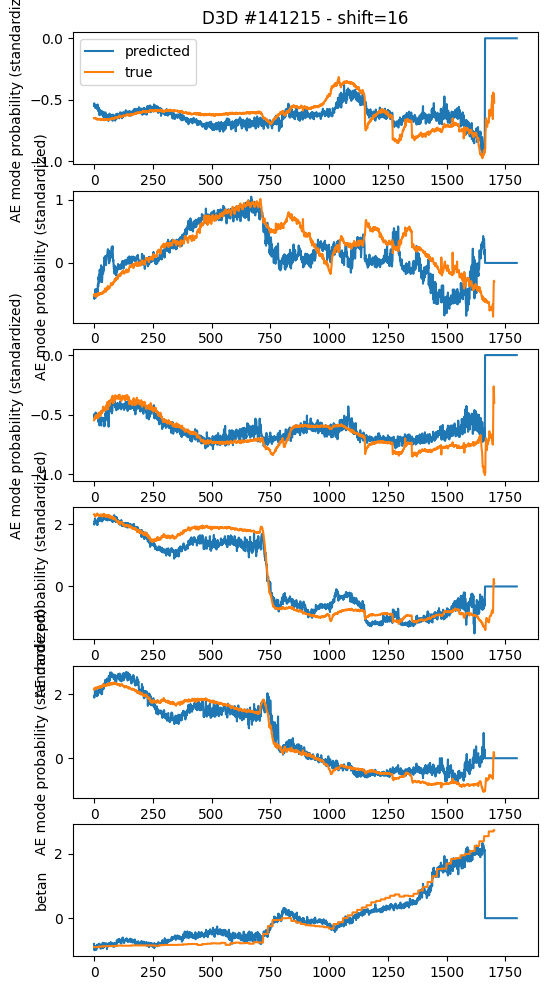

In [ ]:
ix_ds = 1
fig = compare_pred_output(ix_ds, my_trf, ds_valid, shift)
fig.savefig(f"AE_pred_transformertest_{ds_valid.shot(ix_ds).shotnr}_shift{shift}.png")

In [ ]:
2+3